# 
# <center> CBERS-4A IMAGERY FOR MAPPING URBAN LAND COVER IN THE AMAZON  </center>

<br/>

<div style="text-align: center;font-size: 90%;">
    Bruno Dias dos Santos, Michelle Azevedo, Luisa Akemi, Carolina Moutinho Duque de Pinho, Antonio Paez and Silvana Amaral  
    <br/><br/>
    National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    e-mail to: <div><a href="mailto:bruno.santos@inpe.br">bruno.santos@inpe.br</a></div>
    <br/><br/>
</div>
<br/>
<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Abstract.</b> The Brazilian Institute of Geography and Statistics (IBGE) identified Intraurban Typologies in several Brazilian urban concentrations using microdata from the 2010 Census. However, using weighting areas as a spatial unit of analysis and the indicators adopted makes it challenging to replicate the methodology for other areas. This paper aims to adapt the IBGE study to the reality of an Amazonian city, choosing Santarém as study site. To achieve this objective, we adapted the socioeconomic indicators to the Amazonian context. As a result, we identified  six intra-urban typologies through an unsupervised classification, which differ concerning  population profile, housing conditions and location in the study area.
    
Key words — Land cover, GEOBIA, Random Forest, CBERS-4A, Data Mining.

</div>    

<br/>

### Variable treatment and selection

Importing libraries:

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import folium
import mapclassify
import geopandas as gpd
import shapely
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score,ConfusionMatrixDisplay,classification_report,confusion_matrix

Reading the segments with attributes and creating a GeoDataFrame:

In [83]:
features_path = "C:\\Bruno\\packages\\amazonULC\\data-raw\\raw-images\\ULC_maraba_features.csv"

features = pd.read_csv(features_path)

In [84]:
shape_path = "C:\\Bruno\\packages\\amazonULC\\data-raw\\raw-images\\ULC_maraba.shp"

shape = gpd.read_file(shape_path)

In [85]:
features

,ID,ASM_max,ASM_mean,ASM_min,ASM_range,ASM_std,ASM_sum,B0_amplitu,B0_contr,B0_dissimi,...,SV_min,SV_range,SV_std,SV_sum,VAR_max,VAR_mean,VAR_min,VAR_range,VAR_std,VAR_sum
0,7,0.297743,0.257378,0.217014,0.080729,0.040365,0.514757,5.0,1136.500000,24.166667,...,4.258314e+03,3.089752e+04,1.544876e+04,3.941415e+04,0.374132,0.305773,0.237413,0.136719,0.068359,0.611545
1,8,0.401910,0.312066,0.222222,0.179687,0.089844,0.624132,2.0,1152.000000,24.000000,...,4.016754e+04,1.801104e+04,9.005521e+03,9.834612e+04,0.405816,0.300781,0.195747,0.210069,0.105035,0.601563
2,10,0.136285,0.121962,0.107639,0.028646,0.014323,0.243924,9.0,1740.500000,29.500000,...,5.431706e+05,6.159884e+05,3.079942e+05,1.702330e+06,15.341579,12.716580,10.091580,5.249999,2.625000,25.433160
3,11,1.000000,0.766493,0.532986,0.467014,0.233507,1.532986,2.0,1568.333333,32.333333,...,0.000000e+00,7.294202e+04,3.647101e+04,7.294202e+04,0.138021,0.069010,0.000000,0.138021,0.069010,0.138021
4,12,0.264757,0.233941,0.203125,0.061632,0.030816,0.467882,4.0,2368.666667,48.666667,...,1.124782e+04,1.413959e+05,7.069794e+04,1.638915e+05,0.513455,0.505859,0.498264,0.015191,0.007595,1.011719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232394,154774,0.157118,0.127894,0.111111,0.046007,0.020741,0.383681,35.0,1738.944444,31.055556,...,2.395774e+05,9.418146e+05,4.097428e+05,2.431854e+06,16.238716,11.222657,5.530382,10.708334,4.397731,33.667970
232395,154789,0.126736,0.111304,0.104167,0.022569,0.007283,1.001736,300.0,4027.466667,45.533333,...,1.317084e+06,3.788496e+06,1.106177e+06,2.606574e+07,875.529053,195.134449,14.516493,861.012560,294.209863,1756.210041
232396,154780,0.125000,0.111690,0.104167,0.020833,0.006774,0.670139,53.0,2802.583333,44.416667,...,4.791407e+05,1.870929e+06,6.350738e+05,7.971417e+06,24.657986,19.643012,9.964410,14.693576,5.520355,117.858071
232397,154777,0.104167,0.104167,0.104167,0.000000,0.000000,0.416667,68.0,2771.625000,34.625000,...,2.674687e+06,8.715295e+05,3.281856e+05,1.207253e+07,99.789932,68.032010,53.544708,46.245224,18.490715,272.128040


In [86]:
obj = features.merge(shape, left_on='ID', right_on='ID')
obj

,ID,ASM_max,ASM_mean,ASM_min,ASM_range,ASM_std,ASM_sum,B0_amplitu,B0_contr,B0_dissimi,...,SV_std,SV_sum,VAR_max,VAR_mean,VAR_min,VAR_range,VAR_std,VAR_sum,TARGET,geometry
0,7,0.297743,0.257378,0.217014,0.080729,0.040365,0.514757,5.0,1136.500000,24.166667,...,1.544876e+04,3.941415e+04,0.374132,0.305773,0.237413,0.136719,0.068359,0.611545,None,"POLYGON ((-49.08163 -5.26413, -49.08152 -5.264..."
1,8,0.401910,0.312066,0.222222,0.179687,0.089844,0.624132,2.0,1152.000000,24.000000,...,9.005521e+03,9.834612e+04,0.405816,0.300781,0.195747,0.210069,0.105035,0.601563,None,"POLYGON ((-49.08152 -5.26426, -49.08146 -5.264..."
2,10,0.136285,0.121962,0.107639,0.028646,0.014323,0.243924,9.0,1740.500000,29.500000,...,3.079942e+05,1.702330e+06,15.341579,12.716580,10.091580,5.249999,2.625000,25.433160,None,"POLYGON ((-49.08254 -5.26453, -49.08249 -5.264..."
3,11,1.000000,0.766493,0.532986,0.467014,0.233507,1.532986,2.0,1568.333333,32.333333,...,3.647101e+04,7.294202e+04,0.138021,0.069010,0.000000,0.138021,0.069010,0.138021,None,"POLYGON ((-49.08189 -5.26459, -49.08186 -5.264..."
4,12,0.264757,0.233941,0.203125,0.061632,0.030816,0.467882,4.0,2368.666667,48.666667,...,7.069794e+04,1.638915e+05,0.513455,0.505859,0.498264,0.015191,0.007595,1.011719,None,"POLYGON ((-49.08150 -5.26462, -49.08148 -5.264..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232394,154774,0.157118,0.127894,0.111111,0.046007,0.020741,0.383681,35.0,1738.944444,31.055556,...,4.097428e+05,2.431854e+06,16.238716,11.222657,5.530382,10.708334,4.397731,33.667970,None,"POLYGON ((-49.00908 -5.37025, -49.00904 -5.370..."
232395,154789,0.126736,0.111304,0.104167,0.022569,0.007283,1.001736,300.0,4027.466667,45.533333,...,1.106177e+06,2.606574e+07,875.529053,195.134449,14.516493,861.012560,294.209863,1756.210041,None,"POLYGON ((-49.02540 -5.37025, -49.02539 -5.370..."
232396,154780,0.125000,0.111690,0.104167,0.020833,0.006774,0.670139,53.0,2802.583333,44.416667,...,6.350738e+05,7.971417e+06,24.657986,19.643012,9.964410,14.693576,5.520355,117.858071,None,"POLYGON ((-49.02185 -5.37040, -49.02176 -5.370..."
232397,154777,0.104167,0.104167,0.104167,0.000000,0.000000,0.416667,68.0,2771.625000,34.625000,...,3.281856e+05,1.207253e+07,99.789932,68.032010,53.544708,46.245224,18.490715,272.128040,None,"POLYGON ((-49.02434 -5.37046, -49.02425 -5.370..."


Inserting the name of the study area to save the classification files:

In [87]:
study_area = 'maraba'

Defining the identifier variable of each feature:

In [88]:
indice = 'ID'

Defining the variable with the sample classes. This variable must be categorical or discrete to perform the classification. We defined the classes: “Shrub Vegetation” (VA), “Herbaceous Vegetation” (VH), “Water” (AG), “Exposed Ground” (SE), “High Gloss Cover” (BR), “Ceramic Cover” (TC), “Fiber Cement Cover” (TF), “Asphalt Road” (AS), “Terrain Road” (ES), “Cloud” (NU) and “Shadow” (SO):

In [89]:
TARGET = 'TARGET'

target = []
cont = 0

for classe in obj[TARGET].unique():
    if not pd.isnull(classe):
        target.append(classe)

target

['HV', 'Ce', 'SV', 'Te', 'As', 'EG', 'Wa', 'HG']

Copying the 'index' and 'geometry' information from the original base to a new GeoDataFrame (geom):

In [90]:
geom = obj[[indice,'geometry']]

In [91]:
type(geom)

pandas.core.frame.DataFrame

Extracting categorical (var_cat) and numerical variables (var_num) for the data treatment:

In [92]:
var_num = pd.DataFrame(obj.select_dtypes(include=['float64','int64','int','float']))
var_cat = pd.DataFrame(obj.select_dtypes(include=['string','object']))

In [93]:
var_cat

,TARGET
0,None
1,None
2,None
3,None
4,None
...,...
232394,None
232395,None
232396,None
232397,None


In [94]:
var_num

,ID,ASM_max,ASM_mean,ASM_min,ASM_range,ASM_std,ASM_sum,B0_amplitu,B0_contr,B0_dissimi,...,SV_min,SV_range,SV_std,SV_sum,VAR_max,VAR_mean,VAR_min,VAR_range,VAR_std,VAR_sum
0,7,0.297743,0.257378,0.217014,0.080729,0.040365,0.514757,5.0,1136.500000,24.166667,...,4.258314e+03,3.089752e+04,1.544876e+04,3.941415e+04,0.374132,0.305773,0.237413,0.136719,0.068359,0.611545
1,8,0.401910,0.312066,0.222222,0.179687,0.089844,0.624132,2.0,1152.000000,24.000000,...,4.016754e+04,1.801104e+04,9.005521e+03,9.834612e+04,0.405816,0.300781,0.195747,0.210069,0.105035,0.601563
2,10,0.136285,0.121962,0.107639,0.028646,0.014323,0.243924,9.0,1740.500000,29.500000,...,5.431706e+05,6.159884e+05,3.079942e+05,1.702330e+06,15.341579,12.716580,10.091580,5.249999,2.625000,25.433160
3,11,1.000000,0.766493,0.532986,0.467014,0.233507,1.532986,2.0,1568.333333,32.333333,...,0.000000e+00,7.294202e+04,3.647101e+04,7.294202e+04,0.138021,0.069010,0.000000,0.138021,0.069010,0.138021
4,12,0.264757,0.233941,0.203125,0.061632,0.030816,0.467882,4.0,2368.666667,48.666667,...,1.124782e+04,1.413959e+05,7.069794e+04,1.638915e+05,0.513455,0.505859,0.498264,0.015191,0.007595,1.011719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232394,154774,0.157118,0.127894,0.111111,0.046007,0.020741,0.383681,35.0,1738.944444,31.055556,...,2.395774e+05,9.418146e+05,4.097428e+05,2.431854e+06,16.238716,11.222657,5.530382,10.708334,4.397731,33.667970
232395,154789,0.126736,0.111304,0.104167,0.022569,0.007283,1.001736,300.0,4027.466667,45.533333,...,1.317084e+06,3.788496e+06,1.106177e+06,2.606574e+07,875.529053,195.134449,14.516493,861.012560,294.209863,1756.210041
232396,154780,0.125000,0.111690,0.104167,0.020833,0.006774,0.670139,53.0,2802.583333,44.416667,...,4.791407e+05,1.870929e+06,6.350738e+05,7.971417e+06,24.657986,19.643012,9.964410,14.693576,5.520355,117.858071
232397,154777,0.104167,0.104167,0.104167,0.000000,0.000000,0.416667,68.0,2771.625000,34.625000,...,2.674687e+06,8.715295e+05,3.281856e+05,1.207253e+07,99.789932,68.032010,53.544708,46.245224,18.490715,272.128040


Removing the sample column for the data treatment:

In [95]:
try: 
    var_cat = var_cat.drop(columns = TARGET)
except:
    var_num = var_num.drop(columns = TARGET)

Removendo outliers dos campos numéricos:

In [96]:
#Function for removing outliers by considering as outlier values greater than 2.698 σ (standard deviation) of the normal distribution curve: 

def rmv_outliers(DataFrame, col_name):
    intervalo = 2.698 * DataFrame[col_name].std()
    media = DataFrame[col_name].mean()
    DataFrame.loc[DataFrame[col_name] < (media - intervalo), col_name] = np.nan
    DataFrame.loc[DataFrame[col_name] > (media + intervalo), col_name] = np.nan

for coluna in var_num.columns:
    rmv_outliers(var_num, coluna)

Normalizing and filling empty values in numeric fields:

In [97]:
#dummy = var_num.iloc[:,1:].mean()
dummy = 0

var_num.iloc[:,1:] = var_num.iloc[:,1:].fillna(dummy)

var_num.iloc[:,1:] = ((var_num.iloc[:,1:] - var_num.iloc[:,1:].min())/(var_num.iloc[:,1:].max() - var_num.iloc[:,1:].min())).round(5)
var_num

,ID,ASM_max,ASM_mean,ASM_min,ASM_range,ASM_std,ASM_sum,B0_amplitu,B0_contr,B0_dissimi,...,SV_min,SV_range,SV_std,SV_sum,VAR_max,VAR_mean,VAR_min,VAR_range,VAR_std,VAR_sum
0,7.0,0.68056,0.79812,0.78864,0.33096,0.52289,0.00133,0.02976,0.13002,0.25000,...,0.00096,0.00730,0.01001,0.00017,0.00050,0.00054,0.00050,0.00029,0.00038,0.00008
1,8.0,0.91865,0.96770,0.80757,0.73665,0.00000,0.00162,0.01190,0.13179,0.24828,...,0.00903,0.00425,0.00583,0.00043,0.00054,0.00053,0.00042,0.00045,0.00058,0.00008
2,10.0,0.31151,0.37820,0.39117,0.11744,0.18554,0.00063,0.05357,0.19911,0.30517,...,0.12208,0.14548,0.19952,0.00742,0.02042,0.02258,0.02145,0.01112,0.01453,0.00337
3,11.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00397,0.01190,0.17942,0.33448,...,0.00000,0.01723,0.02363,0.00032,0.00018,0.00012,0.00000,0.00029,0.00038,0.00002
4,12.0,0.60516,0.72544,0.73817,0.25267,0.39920,0.00121,0.02381,0.27098,0.50345,...,0.00253,0.03339,0.04580,0.00071,0.00068,0.00090,0.00106,0.00003,0.00004,0.00013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232394,154774.0,0.35913,0.39659,0.40379,0.18861,0.26868,0.00099,0.20833,0.19894,0.32126,...,0.05385,0.22243,0.26544,0.01060,0.02161,0.01993,0.01176,0.02269,0.02434,0.00446
232395,154789.0,0.28968,0.34515,0.37855,0.09253,0.09435,0.00260,0.00000,0.46074,0.47103,...,0.29603,0.89474,0.71660,0.11359,0.00000,0.34653,0.03086,0.00000,0.00000,0.23275
232396,154780.0,0.28571,0.34634,0.37855,0.08541,0.08775,0.00174,0.31548,0.32062,0.45948,...,0.10769,0.44186,0.41141,0.03474,0.03282,0.03488,0.02118,0.03113,0.03055,0.01562
232397,154777.0,0.23810,0.32301,0.37855,0.00000,0.00000,0.00108,0.40476,0.31707,0.35819,...,0.60117,0.20583,0.21260,0.05261,0.13281,0.12081,0.11381,0.09799,0.10233,0.03607


Applying OneHotEncoder to variables of a categorical type and creating a DataFrame of the data:

In [98]:
aux = obj[[indice, TARGET]]

try:
    var_cat = pd.get_dummies(var_cat[:-1], drop_first=True)
    obj = (aux.merge(var_num, left_on=indice, right_on=indice)).merge(var_cat, left_index=True, right_index=True)
    
except:
    obj = (aux.merge(var_num, left_on=indice, right_on=indice))
    print("No categorical features to apply OneHotEncode.")

obj

No categorical features to apply OneHotEncode.


,ID,TARGET,ASM_max,ASM_mean,ASM_min,ASM_range,ASM_std,ASM_sum,B0_amplitu,B0_contr,...,SV_min,SV_range,SV_std,SV_sum,VAR_max,VAR_mean,VAR_min,VAR_range,VAR_std,VAR_sum
0,7,None,0.68056,0.79812,0.78864,0.33096,0.52289,0.00133,0.02976,0.13002,...,0.00096,0.00730,0.01001,0.00017,0.00050,0.00054,0.00050,0.00029,0.00038,0.00008
1,8,None,0.91865,0.96770,0.80757,0.73665,0.00000,0.00162,0.01190,0.13179,...,0.00903,0.00425,0.00583,0.00043,0.00054,0.00053,0.00042,0.00045,0.00058,0.00008
2,10,None,0.31151,0.37820,0.39117,0.11744,0.18554,0.00063,0.05357,0.19911,...,0.12208,0.14548,0.19952,0.00742,0.02042,0.02258,0.02145,0.01112,0.01453,0.00337
3,11,None,0.00000,0.00000,0.00000,0.00000,0.00000,0.00397,0.01190,0.17942,...,0.00000,0.01723,0.02363,0.00032,0.00018,0.00012,0.00000,0.00029,0.00038,0.00002
4,12,None,0.60516,0.72544,0.73817,0.25267,0.39920,0.00121,0.02381,0.27098,...,0.00253,0.03339,0.04580,0.00071,0.00068,0.00090,0.00106,0.00003,0.00004,0.00013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232394,154774,None,0.35913,0.39659,0.40379,0.18861,0.26868,0.00099,0.20833,0.19894,...,0.05385,0.22243,0.26544,0.01060,0.02161,0.01993,0.01176,0.02269,0.02434,0.00446
232395,154789,None,0.28968,0.34515,0.37855,0.09253,0.09435,0.00260,0.00000,0.46074,...,0.29603,0.89474,0.71660,0.11359,0.00000,0.34653,0.03086,0.00000,0.00000,0.23275
232396,154780,None,0.28571,0.34634,0.37855,0.08541,0.08775,0.00174,0.31548,0.32062,...,0.10769,0.44186,0.41141,0.03474,0.03282,0.03488,0.02118,0.03113,0.03055,0.01562
232397,154777,None,0.23810,0.32301,0.37855,0.00000,0.00000,0.00108,0.40476,0.31707,...,0.60117,0.20583,0.21260,0.05261,0.13281,0.12081,0.11381,0.09799,0.10233,0.03607


Viewing descriptive statistics of the already processed database:

In [99]:
obj.describe()

,ID,ASM_max,ASM_mean,ASM_min,ASM_range,ASM_std,ASM_sum,B0_amplitu,B0_contr,B0_dissimi,...,SV_min,SV_range,SV_std,SV_sum,VAR_max,VAR_mean,VAR_min,VAR_range,VAR_std,VAR_sum
count,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,...,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000,232399.000000
mean,117657.640424,0.309507,0.369532,0.398840,0.088581,0.102452,0.002176,0.213104,0.302182,0.411474,...,0.227279,0.199086,0.210768,0.028073,0.076310,0.070261,0.056502,0.057529,0.057220,0.025147
std,67972.627052,0.156037,0.151979,0.144666,0.150233,0.160517,0.015523,0.196761,0.185502,0.203485,...,0.211017,0.229292,0.227969,0.053009,0.126597,0.117653,0.108406,0.119533,0.116151,0.065506
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58753.500000,0.253970,0.333780,0.378550,0.000000,0.000000,0.000540,0.053570,0.175090,0.274710,...,0.049750,0.000000,0.000000,0.005150,0.012290,0.012520,0.006010,0.000000,0.000000,0.002080
50%,117532.000000,0.273810,0.354240,0.391170,0.032030,0.044980,0.000830,0.166670,0.275690,0.394830,...,0.180380,0.117820,0.145710,0.014560,0.036300,0.034590,0.023360,0.014310,0.016230,0.007350
75%,176434.500000,0.329370,0.390310,0.419560,0.106760,0.128540,0.001460,0.315480,0.406040,0.543100,...,0.342430,0.333365,0.359750,0.031160,0.080010,0.073600,0.057270,0.058515,0.059585,0.020470
max,235568.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Creating a copy of the already processed DataFrame:

In [100]:
saida =  obj
saida

,ID,TARGET,ASM_max,ASM_mean,ASM_min,ASM_range,ASM_std,ASM_sum,B0_amplitu,B0_contr,...,SV_min,SV_range,SV_std,SV_sum,VAR_max,VAR_mean,VAR_min,VAR_range,VAR_std,VAR_sum
0,7,None,0.68056,0.79812,0.78864,0.33096,0.52289,0.00133,0.02976,0.13002,...,0.00096,0.00730,0.01001,0.00017,0.00050,0.00054,0.00050,0.00029,0.00038,0.00008
1,8,None,0.91865,0.96770,0.80757,0.73665,0.00000,0.00162,0.01190,0.13179,...,0.00903,0.00425,0.00583,0.00043,0.00054,0.00053,0.00042,0.00045,0.00058,0.00008
2,10,None,0.31151,0.37820,0.39117,0.11744,0.18554,0.00063,0.05357,0.19911,...,0.12208,0.14548,0.19952,0.00742,0.02042,0.02258,0.02145,0.01112,0.01453,0.00337
3,11,None,0.00000,0.00000,0.00000,0.00000,0.00000,0.00397,0.01190,0.17942,...,0.00000,0.01723,0.02363,0.00032,0.00018,0.00012,0.00000,0.00029,0.00038,0.00002
4,12,None,0.60516,0.72544,0.73817,0.25267,0.39920,0.00121,0.02381,0.27098,...,0.00253,0.03339,0.04580,0.00071,0.00068,0.00090,0.00106,0.00003,0.00004,0.00013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232394,154774,None,0.35913,0.39659,0.40379,0.18861,0.26868,0.00099,0.20833,0.19894,...,0.05385,0.22243,0.26544,0.01060,0.02161,0.01993,0.01176,0.02269,0.02434,0.00446
232395,154789,None,0.28968,0.34515,0.37855,0.09253,0.09435,0.00260,0.00000,0.46074,...,0.29603,0.89474,0.71660,0.11359,0.00000,0.34653,0.03086,0.00000,0.00000,0.23275
232396,154780,None,0.28571,0.34634,0.37855,0.08541,0.08775,0.00174,0.31548,0.32062,...,0.10769,0.44186,0.41141,0.03474,0.03282,0.03488,0.02118,0.03113,0.03055,0.01562
232397,154777,None,0.23810,0.32301,0.37855,0.00000,0.00000,0.00108,0.40476,0.31707,...,0.60117,0.20583,0.21260,0.05261,0.13281,0.12081,0.11381,0.09799,0.10233,0.03607


Selecting only the sampled features to extract the statistics:

In [101]:
obj = obj[obj[TARGET].isin(target)]
obj

,ID,TARGET,ASM_max,ASM_mean,ASM_min,ASM_range,ASM_std,ASM_sum,B0_amplitu,B0_contr,...,SV_min,SV_range,SV_std,SV_sum,VAR_max,VAR_mean,VAR_min,VAR_range,VAR_std,VAR_sum
197,216,HV,0.00000,0.57339,0.37855,0.00000,0.00000,0.63714,0.63690,0.03357,...,0.00008,0.79950,0.29450,0.00000,0.00000,0.05108,0.00014,0.00000,0.72470,0.00000
408,428,Ce,0.30556,0.36788,0.37855,0.12100,0.11069,0.00185,0.36310,0.15168,...,0.22792,0.47543,0.48866,0.04080,0.04506,0.03295,0.01422,0.05756,0.05215,0.01475
409,429,Ce,0.34524,0.36493,0.37855,0.19217,0.19752,0.00214,0.36310,0.00151,...,0.12167,0.49382,0.38936,0.04475,0.03076,0.03070,0.02395,0.02510,0.02044,0.01604
437,457,Ce,0.31944,0.37349,0.39117,0.13167,0.16029,0.00125,0.40476,0.47455,...,0.09695,0.47991,0.49063,0.02139,0.06106,0.04191,0.02663,0.07066,0.07322,0.01251
466,486,Ce,0.25595,0.34078,0.37855,0.03203,0.03736,0.00142,0.25000,0.28759,...,0.39207,0.32713,0.31872,0.05576,0.05299,0.03883,0.01380,0.07061,0.06837,0.01449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232297,200973,SV,0.96032,0.91570,0.77287,0.85053,0.89173,0.00842,0.05952,0.13988,...,0.00054,0.00749,0.00689,0.00078,0.00120,0.00071,0.00042,0.00150,0.00110,0.00058
232298,200995,SV,0.00000,0.00000,0.00000,0.98221,0.00000,0.00402,0.01786,0.25005,...,0.00022,0.00088,0.00086,0.00005,0.00032,0.00035,0.00026,0.00025,0.00026,0.00011
232301,196934,SV,0.00000,0.00000,0.60252,0.00000,0.00000,0.03850,0.05357,0.07418,...,0.00007,0.03440,0.02336,0.00672,0.00088,0.00059,0.00014,0.00126,0.00085,0.00203
232308,200972,SV,0.00000,0.00000,0.94637,0.00000,0.00000,0.00496,0.02976,0.06321,...,0.00016,0.01251,0.01536,0.00048,0.00033,0.00037,0.00023,0.00030,0.00029,0.00014


Calculate the R² of the Anova of each column against the Target column:

In [102]:
iv = {}

for coluna in obj.columns:  
    if coluna != TARGET:
        counts = obj.groupby(TARGET, sort=True)[coluna].count() # Count of elements in each sample class
        medias = obj.groupby(TARGET, sort=True)[coluna].mean() # Average of each caluna per sample class 
        aux = 0        
        for i in range(len(counts)):
            try:
                aux = aux + counts.iloc[i]*((medias.iloc[i] - obj[coluna].mean())**2)
            except:
                aux = 0
        
        if (sum(counts))*((obj[coluna].std())**2) == 0:
            iv[coluna] = aux/0.00001
        else:                
            iv[coluna] = aux/((sum(counts))*((obj[coluna].std())**2))
        
        print("R² computed for ", coluna)

iv = sorted(iv.items(), key=lambda x: x[1], reverse=True)

R² computed for  ID
R² computed for  ASM_max
R² computed for  ASM_mean
R² computed for  ASM_min
R² computed for  ASM_range
R² computed for  ASM_std
R² computed for  ASM_sum
R² computed for  B0_amplitu
R² computed for  B0_contr
R² computed for  B0_dissimi
R² computed for  B0_energy
R² computed for  B0_entropy
R² computed for  B0_homogen
R² computed for  B0_kurtosi
R² computed for  B0_max
R² computed for  B0_mean
R² computed for  B0_median
R² computed for  B0_min
R² computed for  B0_skewnes
R² computed for  B0_std
R² computed for  B0_sum
R² computed for  B1_amplitu
R² computed for  B1_contr
R² computed for  B1_dissimi
R² computed for  B1_energy
R² computed for  B1_entropy
R² computed for  B1_homogen
R² computed for  B1_kurtosi
R² computed for  B1_max
R² computed for  B1_mean
R² computed for  B1_median
R² computed for  B1_min
R² computed for  B1_skewnes
R² computed for  B1_std
R² computed for  B1_sum
R² computed for  B2_amplitu
R² computed for  B2_contr
R² computed for  B2_dissimi
R² comp

In [103]:
iv

[('NDRI_std', 0.901049666593818),
 ('NDRI_range', 0.8787207774434442),
 ('NDRI_max', 0.8548266575060264),
 ('IFVe_mean', 0.8410678662723563),
 ('IFVe_min', 0.8318190846558501),
 ('IFEG_max', 0.83069943077144),
 ('IFVe_max', 0.7719759816946534),
 ('IFEG_mean', 0.6739779360614229),
 ('B2_max', 0.6673756673082688),
 ('SA_max', 0.637509516214538),
 ('NDVI_max', 0.6275735922218493),
 ('B2_mean', 0.6266324913634174),
 ('NDWI_max', 0.6243584254022464),
 ('Road_pres', 0.6217224373283324),
 ('B2_std', 0.609822924478411),
 ('SV_max', 0.6065521368146343),
 ('IFWa_mean', 0.5990094798689968),
 ('SV_std', 0.5985484051456019),
 ('IFEG_min', 0.5942083046868503),
 ('SA_mean', 0.5902339444177536),
 ('B2_median', 0.5877103423589399),
 ('ID', 0.5695479318458564),
 ('MC1_mean', 0.5655036751215757),
 ('B1_max', 0.5465648269351194),
 ('IFWa_max', 0.5403523172569881),
 ('SV_mean', 0.52892451837613),
 ('BAI_range', 0.5220626073193673),
 ('B2_amplitu', 0.5215485936257257),
 ('B2_min', 0.5208288430774203),
 ('SV

Bloxpot plot of the variable with the best explaining power in relation to the sample classes:

<AxesSubplot: xlabel='TARGET', ylabel='NDRI_std'>

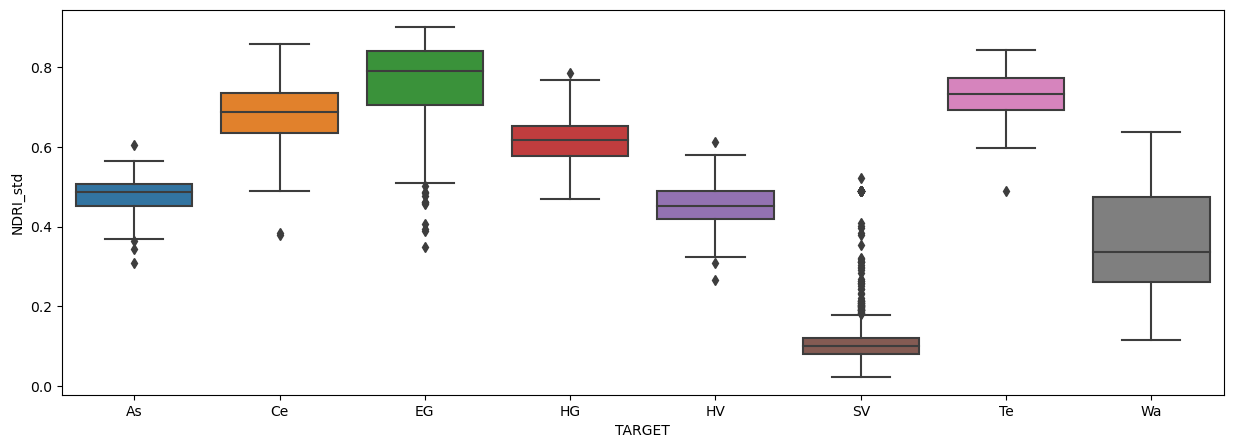

In [104]:
plt.figure(figsize=(15,5))
sns.boxplot(x=TARGET , y= obj[iv[0][0]], order= obj[TARGET].sort_values().unique(), data = obj)

Bloxpot plot of the variable with the worst explaining power in relation to the sample classes:

<AxesSubplot: xlabel='TARGET', ylabel='POL_ANGLE'>

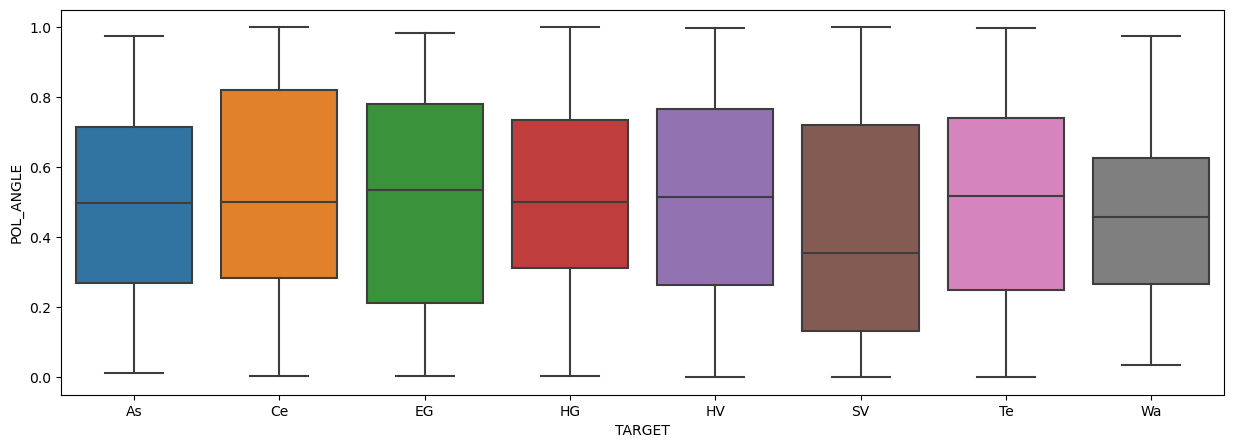

In [105]:
plt.figure(figsize=(15,5))
sns.boxplot(x=TARGET , y= obj[iv[-1][0]], order= obj[TARGET].sort_values().unique(), data = obj)

Removing poorly explanatory variables from a threshold and variables with possible 'NaN' values:

In [106]:
lim_min = 0.1
aux = []

print(f'Total variables before removal: {len(iv)}')

for i in range(len(iv)):
    if math.isnan(iv[i][1]):
        aux.append(iv[i])
    elif iv[i][0] != indice:
        if iv[i][1] < lim_min:
            aux.append(iv[i])

for i in aux:
    iv.remove(i)

print(f'Total variables after removal: {len(iv)}')

Total variables before removal: 195
Total variables after removal: 151


Viewing the most explanatory variables:

In [107]:
iv

[('NDRI_std', 0.901049666593818),
 ('NDRI_range', 0.8787207774434442),
 ('NDRI_max', 0.8548266575060264),
 ('IFVe_mean', 0.8410678662723563),
 ('IFVe_min', 0.8318190846558501),
 ('IFEG_max', 0.83069943077144),
 ('IFVe_max', 0.7719759816946534),
 ('IFEG_mean', 0.6739779360614229),
 ('B2_max', 0.6673756673082688),
 ('SA_max', 0.637509516214538),
 ('NDVI_max', 0.6275735922218493),
 ('B2_mean', 0.6266324913634174),
 ('NDWI_max', 0.6243584254022464),
 ('Road_pres', 0.6217224373283324),
 ('B2_std', 0.609822924478411),
 ('SV_max', 0.6065521368146343),
 ('IFWa_mean', 0.5990094798689968),
 ('SV_std', 0.5985484051456019),
 ('IFEG_min', 0.5942083046868503),
 ('SA_mean', 0.5902339444177536),
 ('B2_median', 0.5877103423589399),
 ('ID', 0.5695479318458564),
 ('MC1_mean', 0.5655036751215757),
 ('B1_max', 0.5465648269351194),
 ('IFWa_max', 0.5403523172569881),
 ('SV_mean', 0.52892451837613),
 ('BAI_range', 0.5220626073193673),
 ('B2_amplitu', 0.5215485936257257),
 ('B2_min', 0.5208288430774203),
 ('SV

Defining the correlation factor to be considered.

Given two variables [i,j], the correlation between i and j will be calculated. If the correlation between the two variables is greater than the maximum correlation factor, we will exclude the one with less explanatory power from its R²:

In [108]:
fator = 0.70

Removal of highly correlated _(Pearson)_ variables:

In [109]:
colunas = []
aux = []

for i, j in iv:
    colunas.append(i)
    aux.append(i)

for i in range(len(colunas)):
    for j in range(len(colunas)):
        if j > i and abs(obj[colunas[i]].corr(obj[colunas[j]])) > fator:
            if (colunas[j] in aux) and (colunas[j] != indice):
                aux.remove(colunas[j])
                
aux = sorted(aux)
aux.remove(indice)
aux[:0] = [indice]
aux

['ID',
 'B0_energy',
 'B0_entropy',
 'B2_contr',
 'B3_contr',
 'B3_max',
 'B3_min',
 'BAI_min',
 'COR_max',
 'COR_mean',
 'COR_min',
 'COR_range',
 'COT_max',
 'COT_mean',
 'COT_range',
 'COT_std',
 'DE_range',
 'DE_std',
 'DV_max',
 'DV_std',
 'IDM_max',
 'IDM_mean',
 'IDM_min',
 'IDM_range',
 'IFVe_std',
 'IFWa_mean',
 'IFWa_sum',
 'NDRI_std',
 'NDRI_sum',
 'NDWI_sum',
 'PCIRCLE',
 'PDENSITY',
 'PELLIP_FIT',
 'PGYRATIUS',
 'P_FRACDIM',
 'P_PERARAT',
 'P_PERIM',
 'Road_perc',
 'Road_pres',
 'SA_range',
 'SE_std',
 'SV_sum',
 'VAR_sum']

Output Dataframe variables:

In [110]:
print(f'Total variables after second removal process: {len(aux)}')

Total variables after second removal process: 43


In [111]:
print(f'list of variables remaining after the variable selection process: {aux}')

list of variables remaining after the variable selection process: ['ID', 'B0_energy', 'B0_entropy', 'B2_contr', 'B3_contr', 'B3_max', 'B3_min', 'BAI_min', 'COR_max', 'COR_mean', 'COR_min', 'COR_range', 'COT_max', 'COT_mean', 'COT_range', 'COT_std', 'DE_range', 'DE_std', 'DV_max', 'DV_std', 'IDM_max', 'IDM_mean', 'IDM_min', 'IDM_range', 'IFVe_std', 'IFWa_mean', 'IFWa_sum', 'NDRI_std', 'NDRI_sum', 'NDWI_sum', 'PCIRCLE', 'PDENSITY', 'PELLIP_FIT', 'PGYRATIUS', 'P_FRACDIM', 'P_PERARAT', 'P_PERIM', 'Road_perc', 'Road_pres', 'SA_range', 'SE_std', 'SV_sum', 'VAR_sum']


Visualizing the correlation between variables:

In [112]:
corr_df = obj[aux[1:]].corr()

corr_df.style.background_gradient(cmap='Spectral')

,B0_energy,B0_entropy,B2_contr,B3_contr,B3_max,B3_min,BAI_min,COR_max,COR_mean,COR_min,COR_range,COT_max,COT_mean,COT_range,COT_std,DE_range,DE_std,DV_max,DV_std,IDM_max,IDM_mean,IDM_min,IDM_range,IFVe_std,IFWa_mean,IFWa_sum,NDRI_std,NDRI_sum,NDWI_sum,PCIRCLE,PDENSITY,PELLIP_FIT,PGYRATIUS,P_FRACDIM,P_PERARAT,P_PERIM,Road_perc,Road_pres,SA_range,SE_std,SV_sum,VAR_sum
B0_energy,1.000000,-0.669399,-0.169333,0.111145,0.065627,0.166191,-0.347924,-0.357500,-0.143116,0.223847,-0.422776,-0.093532,-0.048027,-0.191669,-0.152065,-0.371711,-0.374091,-0.019996,-0.110088,0.102416,0.027731,0.033275,-0.263826,-0.305013,-0.252523,-0.049544,-0.243282,-0.383142,-0.328235,-0.065448,-0.352722,-0.017442,-0.326120,0.296534,0.466286,-0.169490,-0.007454,-0.115578,-0.342193,-0.340007,-0.138380,-0.123311
B0_entropy,-0.669399,1.000000,0.196150,-0.154640,-0.063072,-0.205554,0.441982,0.457810,0.131543,-0.338178,0.546156,0.147844,0.061906,0.208600,0.193845,0.455345,0.482375,-0.022513,0.059684,-0.117283,-0.027584,-0.078505,0.372556,0.396081,0.308592,0.023119,0.312183,0.440857,0.392338,0.178453,0.403959,-0.194858,0.392732,-0.143059,-0.502272,0.279742,0.114851,0.250723,0.457526,0.379488,0.213320,0.156387
B2_contr,-0.169333,0.196150,1.000000,0.149513,-0.083170,0.018452,0.069446,0.193718,0.217269,0.096466,0.128935,0.169775,0.293466,0.140852,0.159981,0.189182,0.125773,-0.401224,-0.155050,-0.313843,-0.294128,-0.245007,0.114193,0.016964,0.206185,-0.061069,0.662604,0.181961,0.073545,0.069317,0.014427,-0.042473,0.117699,0.026389,-0.070205,-0.001566,0.100912,0.197187,0.316200,0.015880,0.103138,0.114495
B3_contr,0.111145,-0.154640,0.149513,1.000000,0.218583,0.393922,-0.326401,-0.340049,-0.119527,0.209155,-0.253098,-0.168735,-0.011529,-0.229677,-0.179001,-0.151029,-0.277643,0.077218,-0.073124,0.142040,0.081453,0.147452,-0.086953,-0.304773,-0.381289,-0.226613,-0.175712,-0.323583,-0.228803,-0.198336,-0.250953,0.143694,-0.267925,0.256044,0.342174,-0.293779,-0.116292,-0.259875,-0.183991,-0.170233,-0.279099,-0.209649
B3_max,0.065627,-0.063072,-0.083170,0.218583,1.000000,0.438627,-0.122370,-0.137378,-0.131303,-0.032013,-0.049233,-0.144981,-0.079392,-0.174236,-0.207669,-0.080097,-0.088012,0.198333,0.039636,0.183155,0.136768,0.165804,0.005177,-0.010136,-0.245899,-0.038649,-0.229723,-0.127854,-0.053753,-0.101841,-0.055784,0.016708,-0.090470,0.077852,0.065600,-0.006722,-0.028354,-0.090675,-0.127543,0.022123,-0.130007,-0.131053
B3_min,0.166191,-0.205554,0.018452,0.393922,0.438627,1.000000,-0.323684,-0.340985,-0.128016,0.198891,-0.217661,-0.228292,-0.034419,-0.240214,-0.258437,-0.141861,-0.270465,0.098148,-0.103810,0.180125,0.025655,0.147362,-0.053510,-0.315571,-0.393457,-0.258041,-0.209031,-0.292328,-0.163829,-0.177958,-0.200441,0.120369,-0.203151,0.300734,0.351245,-0.225340,-0.075018,-0.210131,-0.178840,-0.160218,-0.253420,-0.197793
BAI_min,-0.347924,0.441982,0.069446,-0.326401,-0.122370,-0.323684,1.000000,0.441452,0.128964,-0.333281,0.436503,0.208302,0.068697,0.285874,0.244622,0.323685,0.423238,-0.074071,0.124381,-0.144781,-0.075540,-0.184640,0.197738,0.572584,0.498628,0.228357,0.291520,0.573937,0.555757,0.130511,0.393561,-0.146450,0.361363,-0.266426,-0.515110,0.370249,0.158558,0.361572,0.341023,0.334173,0.356780,0.294423
COR_max,-0.357500,0.457810,0.193718,-0.340049,-0.137378,-0.340985,0.441452,1.000000,0.675656,-0.113313,0.591511,0.307203,0.146864,0.340388,0.301795,0.375361,0.557031,-0.072561,0.122603,-0.237222,-0.131424,-0.234428,0.267296,0.426610,0.383424,0.284830,0.428154,0.457235,0.360994,0.177315,0.427919,-0.216049,0.402059,-0.336482,-0.586951,0.424046,0.170356,0.345701,0.398125,0.375237,0.416145,0.352120
COR_mean,-0.143116,0.131543,0.217269,-0.119527,-0.131303,-0.128016,0.128964,0.675656,1.000000,0.577293,0.064609,0.184210,0.205213,0.122211,0.152440,0.102357,0.124410,-0.176114,-0.024155,-0.216961,-0.241082,-0.245055,0.001000,0.061359,0.146579,0.065546,0.317324,0.168750,0.083340,0.052050,0.119889,-0.018153,0.118688,-0.116001,-0.134225,0.083554,0.055983,0.090123,0.149841,-

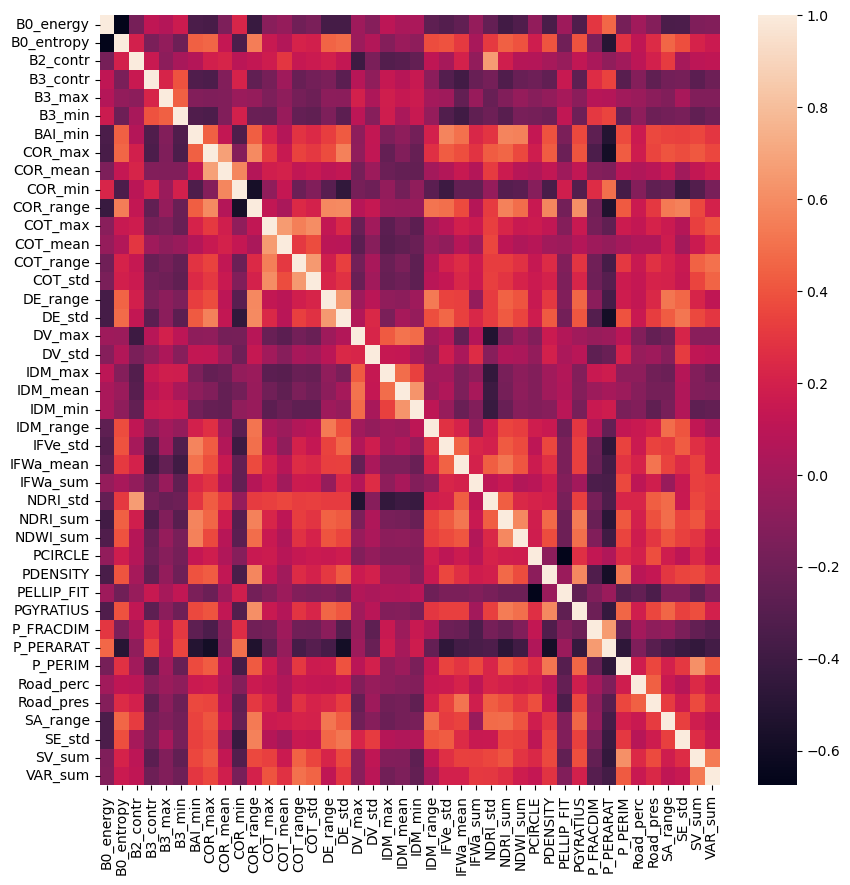

In [113]:
corr_df = obj[aux[1:]].corr(method='pearson')

plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, annot=False)
plt.show()

In [114]:
aux.append(TARGET)

Saving a csv with the treated data:

In [115]:
geom = geom.merge(saida[aux], left_on=indice, right_on=indice)
geom

,ID,geometry,B0_energy,B0_entropy,B2_contr,B3_contr,B3_max,B3_min,BAI_min,COR_max,...,P_FRACDIM,P_PERARAT,P_PERIM,Road_perc,Road_pres,SA_range,SE_std,SV_sum,VAR_sum,TARGET
0,7,"POLYGON ((-49.08163 -5.26413, -49.08152 -5.264...",0.40825,0.53872,0.02891,0.41556,0.85570,0.61760,0.06224,0.37308,...,0.86854,0.52154,0.03466,0.00000,0.0,0.14457,0.37837,0.00017,0.00008,None
1,8,"POLYGON ((-49.08152 -5.26426, -49.08146 -5.264...",0.50000,0.41681,0.03181,0.46366,0.78211,0.88494,0.04887,0.31455,...,0.84257,0.47917,0.02426,0.00000,0.0,0.04693,0.54019,0.00043,0.00008,None
2,10,"POLYGON ((-49.08254 -5.26453, -49.08249 -5.264...",0.70711,0.20841,0.14042,0.21731,0.54978,0.60237,0.00000,0.76862,...,0.91960,0.71429,0.02600,0.00000,0.0,0.20382,0.24680,0.00742,0.00337,None
3,11,"POLYGON ((-49.08189 -5.26459, -49.08186 -5.264...",0.57735,0.33032,0.04380,0.54544,0.77056,0.80541,0.10904,0.44528,...,0.87475,0.56650,0.02600,0.00000,0.0,0.31683,0.00000,0.00032,0.00002,None
4,12,"POLYGON ((-49.08150 -5.26462, -49.08148 -5.264...",0.74536,0.19138,0.06813,0.00000,0.86580,0.90355,0.02967,0.55658,...,0.85701,0.51339,0.02600,0.00000,0.0,0.27465,0.06170,0.00071,0.00013,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232394,154774,"POLYGON ((-49.00908 -5.37025, -49.00904 -5.370...",0.50308,0.49854,0.09251,0.10937,0.47763,0.00000,0.88612,0.36543,...,0.86942,0.48190,0.05719,0.00000,0.0,0.42381,0.40721,0.01060,0.00446,None
232395,154789,"POLYGON ((-49.02540 -5.37025, -49.02539 -5.370...",0.39441,0.75827,0.45125,0.31757,0.86291,0.59898,0.40572,0.71711,...,0.90363,0.55200,0.10919,0.45947,1.0,0.72044,0.38376,0.11359,0.23275,None
232396,154780,"POLYGON ((-49.02185 -5.37040, -49.02176 -5.370...",0.33333,0.67766,0.29642,0.38681,0.71861,0.60237,0.33291,0.65137,...,0.81350,0.32561,0.05719,0.00000,0.0,0.53087,0.47942,0.03474,0.01562,None
232397,154777,"POLYGON ((-49.02434 -5.37046, -49.02425 -5.370...",0.39528,0.57312,0.38858,0.44510,0.86291,0.78511,0.11997,0.81690,...,0.92575,0.69048,0.05026,0.00000,0.0,0.23907,0.00000,0.05261,0.03607,None


In [116]:
geom.to_csv("C:\\Bruno\\packages\\amazonULC\\data-raw\\data-outputs\\maraba_treated.csv", index=False)

### Supervision Classification of the land cover

Selecting only the database with samples to build the supervised classification model:

In [117]:
amostras = geom.replace(to_replace='None', value=np.nan).dropna()
amostras

,ID,geometry,B0_energy,B0_entropy,B2_contr,B3_contr,B3_max,B3_min,BAI_min,COR_max,...,P_FRACDIM,P_PERARAT,P_PERIM,Road_perc,Road_pres,SA_range,SE_std,SV_sum,VAR_sum,TARGET
197,216,"POLYGON ((-49.08395 -5.27148, -49.08393 -5.271...",0.33242,0.00000,0.02509,0.04950,0.75613,0.51946,0.60905,0.93912,...,0.00000,0.00000,0.00000,0.00004,1.0,0.00000,0.92170,0.00000,0.00000,HV
408,428,"POLYGON ((-49.09509 -5.27419, -49.09507 -5.274...",0.39528,0.57312,0.21560,0.21553,0.84848,0.81895,0.44295,0.72166,...,0.82380,0.36508,0.04853,0.00000,0.0,0.49529,0.24934,0.04080,0.01475,Ce
409,429,"POLYGON ((-49.09487 -5.27416, -49.09482 -5.274...",0.54006,0.47777,0.00966,0.00616,0.84704,0.80711,0.57134,0.74089,...,0.86126,0.45412,0.05893,0.10381,1.0,0.54536,0.43876,0.04475,0.01604,Ce
437,457,"POLYGON ((-49.09457 -5.27421, -49.09448 -5.274...",0.35355,0.62522,0.62953,0.70047,0.87446,0.77496,0.21138,0.65394,...,0.88865,0.54762,0.05546,0.00000,0.0,0.63294,0.25874,0.02139,0.01251,Ce
466,486,"POLYGON ((-49.09278 -5.27437, -49.09271 -5.274...",0.35355,0.62522,0.40259,0.44417,0.77345,0.70051,0.11078,0.79414,...,0.92908,0.69505,0.05719,0.00000,0.0,0.31297,0.36244,0.05576,0.01449,Ce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232297,200973,"POLYGON ((-49.05973 -5.38886, -49.05971 -5.388...",0.37192,0.63751,0.02912,0.58320,0.88456,0.71404,0.22009,0.59580,...,0.83044,0.33917,0.08319,0.00000,0.0,0.16365,0.75823,0.00078,0.00058,SV
232298,200995,"POLYGON ((-49.06090 -5.38909, -49.06089 -5.389...",0.61237,0.31261,0.05206,0.74658,0.70996,0.68359,0.25112,0.59580,...,0.87195,0.52381,0.03813,0.00000,0.0,0.04620,0.50796,0.00005,0.00011,SV
232301,196934,"POLYGON ((-49.06247 -5.38888, -49.06246 -5.388...",0.42388,0.65540,0.01577,0.27063,0.90620,0.72927,0.13107,0.88582,...,0.77305,0.16315,0.18718,0.00000,0.0,0.37382,0.81994,0.00672,0.00203,SV
232308,200972,"POLYGON ((-49.06123 -5.38897, -49.06121 -5.388...",0.50000,0.41681,0.01233,0.26623,0.89899,0.82572,0.14182,0.44528,...,0.87426,0.48824,0.06412,0.00000,0.0,0.23481,0.70629,0.00048,0.00014,SV


Separating the training and validation data:

In [118]:
X = pd.DataFrame(amostras.iloc[:,2:-1])
Y = pd.DataFrame(amostras[TARGET]).to_numpy()

In [119]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state=42)

In [120]:
x_train.shape

(1486, 42)

In [121]:
y_train.shape

(1486, 1)

In [122]:
x_test.shape

(637, 42)

In [123]:
y_test.shape

(637, 1)

Visualizing the sample classes and the count of features per class:

In [124]:
amostras[TARGET].unique()

array(['HV', 'Ce', 'SV', 'Te', 'As', 'EG', 'Wa', 'HG'], dtype=object)

In [125]:
amostras.groupby(TARGET)[indice].nunique()

TARGET
As     113
Ce     201
EG     116
HG     159
HV     167
SV    1197
Te     118
Wa      52
Name: ID, dtype: int64

Selection of hyperparameters and values for RandomizedSearchCV. In this technique, we input the algorithm values of hyperparameters that will be randomly selected and combined, returning a combination that results in the best possible classification. The algorithm uses a performance metric and a predetermined number of iterations to choose the best combination of hyperparameters. Randomized Search uses cross-validation, dividing the training base into k parts (folds), and the model is trained and evaluated k times. For each iteration, the algorithm selects a part (fold) that will serve as an evaluation and trains the model on the other k -1 parts:

In [126]:
parametros = {'n_estimators':[1,20,50,100,150,200,250,300,350,400,450,500,550,600,700,800,900,1000,1500,2000],
              'criterion':['gini','entropy'],
              'max_depth':[5,10,20, None],
              'min_samples_split':[2,5,10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}

Defining the RandomizedSearchCV (with K-fold = 5):

In [127]:
modelo = RandomizedSearchCV(estimator = RandomForestClassifier(), n_iter = 100, verbose=2, random_state=42, param_distributions = parametros, scoring='f1_macro', n_jobs=-1, cv=5)

Designing the Random Forest classification model:

In [128]:
modelo.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\brdia\anaconda3\envs\environment\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1, 20, 50, 100, 150,
                                                         200, 250, 300, 350,
                                                         400, 450, 500, 550,
                                                         600, 700, 800, 900,
                                                         1000, 1500, 2000]},
                   random_state=42, scoring='f1_macro', verbose=2)

Visualizing the best combination of hyperparameters:

In [129]:
modelo.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': False}

In [130]:
modelo.best_score_

0.8907725865959446

In [131]:
modelo.best_estimator_

RandomForestClassifier(bootstrap=False, criterion='entropy',
                       min_samples_split=5, n_estimators=300)

Using the trained model to predict the validation database:

In [132]:
y_pred = modelo.predict(x_test)

Viewing the most used variables in the Random Forest model:

<BarContainer object of 42 artists>

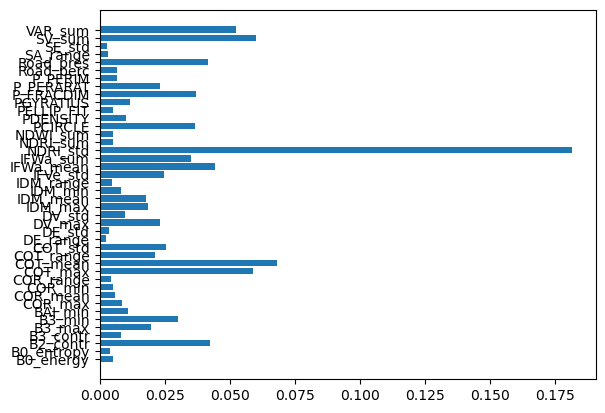

In [133]:
plt.barh(x_test.columns, modelo.best_estimator_.feature_importances_ )

Viewing performance metrics of the classification model:

In [134]:
macro = f1_score(y_test, y_pred, average = 'macro')
wei = f1_score(y_test, y_pred, average = 'weighted')
accuracy = accuracy_score(y_test, y_pred)

results = {'F1_Score_Macro': macro,
             'F1_Score_Weighted': wei,
             'Global Acuraccy': accuracy 
            }

pd.DataFrame.from_dict(results, orient='index', dtype=None, columns=['Metrics'])

,Metrics
F1_Score_Macro,0.902144
F1_Score_Weighted,0.949565
Global Acuraccy,0.949765


Confusion matrix:

In [135]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 33   0   0   0   1   0   0   0]
 [  0  53   0   2   4   0   1   0]
 [  2   2  26   0   3   0   2   0]
 [  0   1   0  47   0   0   0   0]
 [  0   1   1   1  47   0   0   0]
 [  0   1   0   1   0 356   0   1]
 [  0   3   0   2   0   0  30   0]
 [  0   0   0   0   3   0   0  13]]
              precision    recall  f1-score   support

          As       0.94      0.97      0.96        34
          Ce       0.87      0.88      0.88        60
          EG       0.96      0.74      0.84        35
          HG       0.89      0.98      0.93        48
          HV       0.81      0.94      0.87        50
          SV       1.00      0.99      1.00       359
          Te       0.91      0.86      0.88        35
          Wa       0.93      0.81      0.87        16

    accuracy                           0.95       637
   macro avg       0.91      0.90      0.90       637
weighted avg       0.95      0.95      0.95       637



In [136]:
data = {'Reference': y_test.flatten(), 'Predicted': y_pred}
df = pd.DataFrame(data, columns = ['Reference','Predicted'])
mc = pd.crosstab(df['Reference'], df['Predicted'], rownames=['Reference'], colnames=['Predicted'])

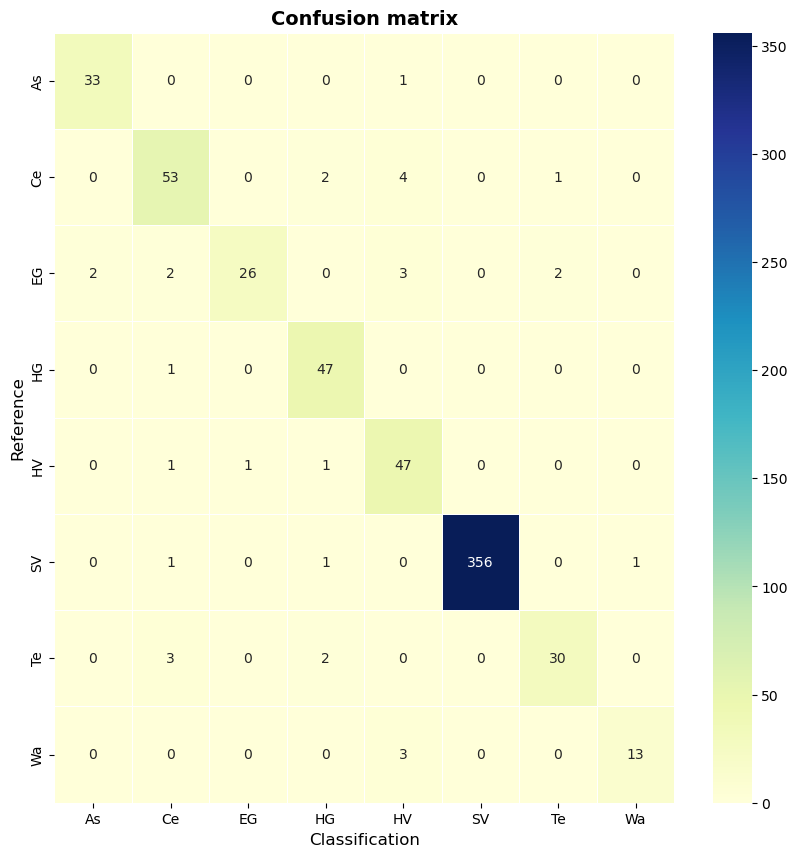

In [137]:
plt.figure(figsize=(10,10))
sns.heatmap(mc, annot=True,fmt='g',  cmap = 'YlGnBu',linewidths=.5)
plt.title('Confusion matrix', fontweight='bold', fontsize=14)
plt.xlabel('Classification', fontsize=12)
plt.ylabel('Reference',fontsize=12)
plt.show()

In [138]:
classe = []
Accuracy = []
Precision = []
Recall = []
F1_Score = []

for i in range(mc.shape[0]):
    TP = mc.iloc[i,i]
    FP = mc.iloc[i,:].sum() - TP
    FN = mc.iloc[:,i].sum() - TP
    TN = mc.sum().sum()-TP-FP-FN
    
    classe.append(mc.index[i]) 
    Accuracy.append((TP+TN)/mc.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    F1_Score.append(((2*Precision[i]*Recall[i])/(Precision[i] + Recall[i])))
    

avaliacao = {'classe': classe,
            'Precision': Precision,
             'Recall': Recall,
             'F1_Score':F1_Score,
             'Acuraccy':Accuracy
            }
       
pd.DataFrame(avaliacao)

,classe,Precision,Recall,F1_Score,Acuraccy
0,As,0.970588,0.942857,0.956522,0.995290
1,Ce,0.883333,0.868852,0.876033,0.976452
2,EG,0.742857,0.962963,0.838710,0.984301
3,HG,0.979167,0.886792,0.930693,0.989011
4,HV,0.940000,0.810345,0.870370,0.978022
5,SV,0.991643,1.000000,0.995804,0.995290
6,Te,0.857143,0.909091,0.882353,0.987441
7,Wa,0.812500,0.928571,0.866667,0.993721


Inserting the classification ('CLASS') into the database shapefile:

In [139]:
geom['CLASS'] = modelo.predict(geom.iloc[:,2:-1])

In [140]:
geom = gpd.GeoDataFrame(geom, geometry='geometry')

In [141]:
colunas_geo = list(geom.columns)
colunas_geo.remove('geometry')
colunas_geo.append('geometry')

colunas_geo

['ID',
 'B0_energy',
 'B0_entropy',
 'B2_contr',
 'B3_contr',
 'B3_max',
 'B3_min',
 'BAI_min',
 'COR_max',
 'COR_mean',
 'COR_min',
 'COR_range',
 'COT_max',
 'COT_mean',
 'COT_range',
 'COT_std',
 'DE_range',
 'DE_std',
 'DV_max',
 'DV_std',
 'IDM_max',
 'IDM_mean',
 'IDM_min',
 'IDM_range',
 'IFVe_std',
 'IFWa_mean',
 'IFWa_sum',
 'NDRI_std',
 'NDRI_sum',
 'NDWI_sum',
 'PCIRCLE',
 'PDENSITY',
 'PELLIP_FIT',
 'PGYRATIUS',
 'P_FRACDIM',
 'P_PERARAT',
 'P_PERIM',
 'Road_perc',
 'Road_pres',
 'SA_range',
 'SE_std',
 'SV_sum',
 'VAR_sum',
 'TARGET',
 'CLASS',
 'geometry']

In [142]:
geom = geom[colunas_geo]

Viewing the Land cover classification map:

<AxesSubplot: >

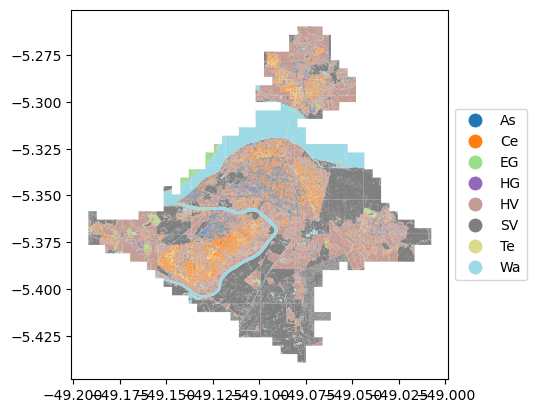

In [143]:
geom.plot(column ='CLASS', legend=True, cmap = 'tab20', categorical=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

In [144]:
#geom.explore(column="CLASS", tooltip="CLASS",tiles="CartoDB positron", categorical = True, cmap='Set2', style_kwds=dict(color="grey", weight=0.01))

Exporting the txt with classification information:

In [145]:
path = "C:\\Bruno\\packages\\amazonULC\\data-raw\\data-outputs\\" + study_area + "_informations.txt"

infos = open(path,"w",encoding='utf-8')

list_informations = []
list_informations.append((str(modelo.best_params_)))
list_informations.append((str(results)))

for line in list_informations:
    infos.write(line)
    infos.write('\n')
    
print(classification_report(y_test, y_pred), file = infos)
print(confusion_matrix(y_test, y_pred), file = infos)

infos.close()

Exporting the shapefile with classification:

In [146]:
geom.to_file("C:\\Bruno\\packages\\amazonULC\\data-raw\\data-outputs\\ULC_maraba_classified.shp")

In [147]:
#geom[[indice,TARGET,'CLASS', 'geometry']].to_file("C:\\Bruno\\packages\\amazonULC\\data-raw\\data-outputs\\ULC_cameta_classified.shp")